# 07: ML vs likelihood comparison 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'pgf.texsystem':'pdflatex'})
import numpy as np
import SMEFT19
from flavio.statistics.functions import delta_chi2
from SMEFT19.utils import listpoint
import flavio.plots.colors
import scipy

/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mlpoints = pd.read_csv('../data/samples/mlpoints.dat', sep='\t')

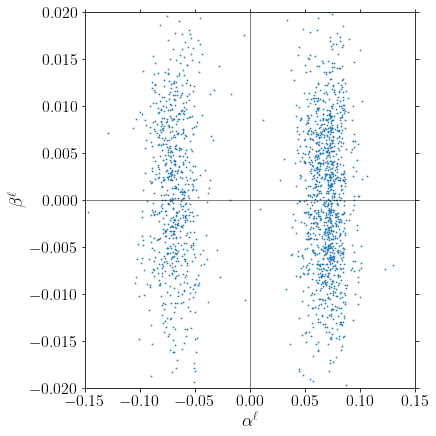

In [4]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['al'], mlpoints['bl'], s=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.02, 0.02])
plt.xlabel(r'$\alpha^\ell$', fontsize=18)
plt.ylabel(r'$\beta^\ell$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_albl.pdf')

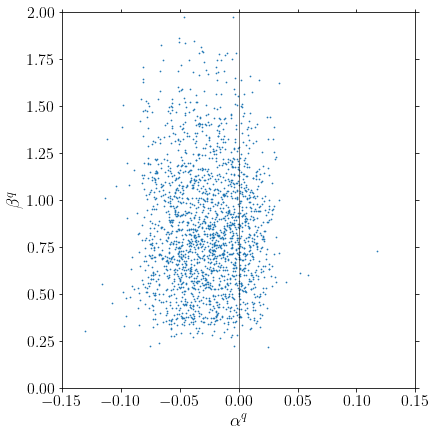

In [5]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['aq'], mlpoints['bq'], s=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([0.0, 2.0])
plt.xlabel(r'$\alpha^q$', fontsize=18)
plt.ylabel(r'$\beta^q$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_aqbq.pdf')

In [6]:
def read_meshgrid(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t')
    xcoords = np.linspace(zdata['x'].min(), zdata['x'].max(), stepx)
    ycoords = np.linspace(zdata['y'].min(), zdata['y'].max(), stepy)
    fitcodes = {r'$R_{K^{(*)}}$':'likelihood_lfu_fcnc.yaml', r'$R_{D^{(*)}}$':'likelihood_rd_rds.yaml',
                'LFV':'likelihood_lfv.yaml', 'Global':'global'}
    d = {}
    for k, v in zip(fitcodes.keys(), fitcodes.values()):
        z = np.array(zdata[v]).reshape(stepx, stepy)
        d.update({k:z})
    return (xcoords, ycoords, {'Global':d['Global']})

In [7]:
d_ell = SMEFT19.ellipse.load('../data/ellipses/rotBII.yaml')
bf1 = d_ell['bf']

In [8]:
def hatch_contour2(x, y, z, levels, interpolation_factor=1, interpolation_order=2, col=0,
                  label=None, hatched=True, contour_args=None, contourf_args=None):
    r"""
Plots coloured and hatched confidence contours (or bands) given numerical
input arrays.Based on the `flavio` function
:Arguments:
    - x, y\: 2D arrays containg x and y values as returned by numpy.meshgrid
    - z\: value of the function to plot. 2D array in the same shape as `x` and
      `y`. The lowest value of the function should be 0 (i.e. the best fit point).
    - levels\: list of function values where to draw the contours. They should
      be positive and in ascending order.
    - [interpolation factor\:: in between the points on the grid,
      the functioncan be interpolated to get smoother contours.
      This parameter sets the number of subdivisions (default: 1, i.e. no
      interpolation). It should be larger than 1.]
    - [col\: number between 0 and 9 to choose the color of the plot
      from a predefined palette.]
    - [label\: label that will be added to a legend created with `maplotlib.pyplot.legend()`.]
    - [contour_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contour()` (that draws the contour lines).]
    - [contourf_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contourf()` (that paints the contour filling).]
    """
    contour_args = contour_args or {}
    contourf_args = contour_args or {}
    if interpolation_factor > 1:
        x = scipy.ndimage.zoom(x, zoom=interpolation_factor, order=1)
        y = scipy.ndimage.zoom(y, zoom=interpolation_factor, order=1)
        z = scipy.ndimage.zoom(z, zoom=interpolation_factor, order=interpolation_order)
    if isinstance(col, int):
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [flavio.plots.colors.set1[col]]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [flavio.plots.colors.pastel[col] +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]
    else:
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [darken_color(matplotlib.colors.to_rgb(col), 0.7)]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [matplotlib.colors.to_rgb(col) +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]

    if hatched:
        hl = []
        for i in range(0, N):
            hl.append(hatches[col]*(N-i))
        hl.append(None)
        _contourf_args['hatches'] = hl
    _contour_args['linestyles'] = 'solid'
    _contour_args.update(contour_args)
    _contourf_args.update(contourf_args)
    # for the filling, need to add zero contour
    levelsf = [np.min(z)] + list(levels)
    ax = plt.gca()
    CF = ax.contourf(x, y, z, levels=levelsf, **_contourf_args)
    CS = ax.contour(x, y, z, levels=levels, **_contour_args)
    if label is not None:
        CF.collections[0].set_label(label)
    return (CS, CF)

In [10]:
def likelihood_plot2(grid, scatterx, scattery, xmin, xmax, ymin, ymax, axlabels, fout=None, locleg=0, n_sigma=(1, 2),
                    colors=None, styles=None, widths=None, ticks=0.5, bf=None):
    r'''
Plots a contour plot of the log-likelihood of the fit.
:Arguments:
    - grid\: List containing the x coordinates, y corrdinates
      and a dictionary for the likelihood values in the grid.
    - xmin\: Minimum value of the `x` coordinate.
    - xmax\: Maximum value of the `x` coordinate.
    - ymin\: Minimum value of the `y` coordinate.
    - ymax\: Maximum value of the `y` coordinate.
    - axlabels\: List containing two strings to label the `x` and `y` axes.
    - [fout\: Path to the files where the plots will be saved.
      Two files are created, one `.pdf` and one `.pgf` (to use in TeX).
      Extensions are added automatically.]
    - [locleg\: Position of the legend of the plot, using `matplotlib`'s syntaxis.
      Default=0 (best position).]
    - [n_sigma\: List containing the significance (in sigmas) of each contour. Default = (1,2).]
    - [colors\: List with the colors of each contour. Default: flavio palette.]
    - [styles\: List with the linestyles of each contour. Default: All solid.]
    - [widths\: List with the linewidths of each contour. Default: All 1pt.]
    - [ticks\: Interval between ticks in both axes. Default:0.5]
    - [bf\: Coordinates of the best fit point(s). It can be `None` (no point marked)
      or a list containing two floats (one point marked). Default: `None`.]
    '''

    fig = plt.figure(figsize=(6, 6))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    nfits = len(grid[2])
    if colors is None:
        _cols = [i%9 for i in range(nfits)]
    else:
        _cols = colors
    if styles is None:
        lstyle = ['solid',]*nfits
    else:
        lstyle = styles
    if widths is None:
        lwidths = [1,]*nfits
    else:
        lwidths = widths
    x = grid[0]
    y = grid[1]
    zl = grid[2]
    for i, z in enumerate(zl.values()):
        chi = -2*(z.T-np.max(z))
        # get the correct values for 2D confidence/credibility contours for n sigma
        if isinstance(n_sigma, float) or isinstance(n_sigma, int):
            levels = [delta_chi2(n_sigma, dof=2)]
        else:
            levels = [delta_chi2(n, dof=2) for n in n_sigma]
        hatch_contour2(x=x, y=y, z=chi, levels=levels, col=_cols[i], label=list(zl.keys())[i],
                      interpolation_factor=5, hatched=False,
                      contour_args={'linestyles':lstyle[i], 'linewidths':lwidths[i]})
    if bf is not None:
        for p in listpoint(bf):
            plt.scatter(*p, marker='x', color='black')
    plt.scatter(scatterx, scattery, s=1.5, label='ML points')
    plt.xlabel(axlabels[0], fontsize=18)
    plt.ylabel(axlabels[1], fontsize=18)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    ax = fig.gca()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if isinstance(ticks, float):
        xticks = ticks
        yticks = ticks
    else:
        xticks = ticks[0]
        yticks = ticks[1]
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1e-5, xticks))
    ax.yaxis.set_ticks(np.arange(ymin, ymax+1e-5, yticks))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc=locleg, fontsize=16, scatterpoints=5)
    plt.tight_layout(pad=0.5)
    if fout is not None:
        fig.savefig(fout+'.pdf')

linewidths is ignored by contourf


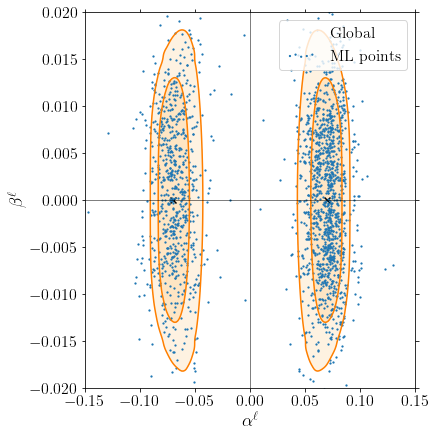

In [11]:
fig = likelihood_plot2(read_meshgrid('../data/likelihood/likelihood_rotBII_l.dat'), mlpoints['al'], mlpoints['bl'],
                -0.15, 0.15, -0.02, 0.02, [r'$\alpha^\ell$', r'$\beta^\ell$'], locleg='upper right',
                colors=[4], bf=([bf1[1], bf1[2]], [-bf1[1], bf1[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.005), fout='../data/plots/ml_albl_global')

linewidths is ignored by contourf


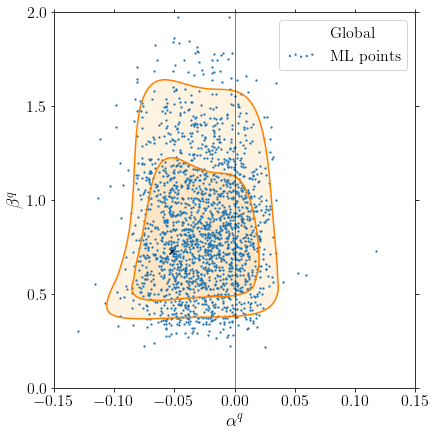

In [12]:
likelihood_plot2(read_meshgrid('../data/likelihood/likelihood_rotBII_q.dat'), mlpoints['aq'], mlpoints['bq'],
                -0.15, 0.15, 0, 2., [r'$\alpha^q$', r'$\beta^q$'], locleg='upper right', ticks=(0.05, 0.5),
                colors=[4], bf=[bf1[3], bf1[4]], widths=[1.5,], fout='../data/plots/ml_aqbq_global')